## Experiment Notebook

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


### Load data

In [3]:
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [4]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((224, 224)),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_dataset_val = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:06<00:00, 27482529.97it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [6]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_val = DataLoader(train_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Load ResNet50 Teacher model

In [7]:
teacher = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 67.4MB/s]


In [8]:
# teacher.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
teacher.fc = nn.Linear(teacher.fc.in_features, 10)
teacher = teacher.to(device)

In [9]:
for param in teacher.parameters():
    param.requires_grad = True

### Fine Tune Teacher on Cifar10

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [11]:
num_epochs = 15
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    teacher.train()

    # Train
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = teacher(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate
    # on training data without augment
    teacher.eval()
    current_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in train_loader_val:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = teacher(inputs)
        loss = criterion(outputs, labels)
        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # on testing data
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = teacher(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()



[1] train_loss: 0.400, train_accuracy: 86.53 %
[1] test_loss: 0.434, test_accuracy: 85.40 %
[2] train_loss: 0.188, train_accuracy: 93.70 %
[2] test_loss: 0.232, test_accuracy: 91.91 %
[3] train_loss: 0.289, train_accuracy: 90.38 %
[3] test_loss: 0.359, test_accuracy: 88.29 %
[4] train_loss: 0.181, train_accuracy: 93.77 %
[4] test_loss: 0.251, test_accuracy: 91.72 %
[5] train_loss: 0.183, train_accuracy: 93.75 %
[5] test_loss: 0.253, test_accuracy: 91.30 %
[6] train_loss: 0.070, train_accuracy: 97.61 %
[6] test_loss: 0.136, test_accuracy: 95.36 %
[7] train_loss: 0.058, train_accuracy: 98.08 %
[7] test_loss: 0.123, test_accuracy: 96.11 %
[8] train_loss: 0.049, train_accuracy: 98.40 %
[8] test_loss: 0.119, test_accuracy: 96.24 %
[9] train_loss: 0.048, train_accuracy: 98.47 %
[9] test_loss: 0.122, test_accuracy: 96.00 %
[10] train_loss: 0.041, train_accuracy: 98.62 %
[10] test_loss: 0.120, test_accuracy: 96.06 %
[11] train_loss: 0.037, train_accuracy: 98.81 %
[11] test_loss: 0.113, test_ac

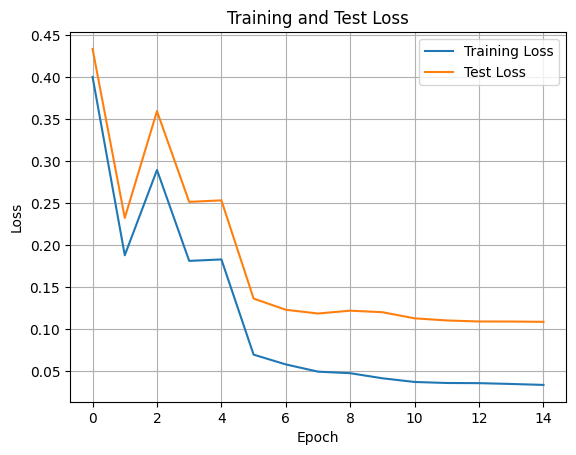

In [12]:
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid()
plt.show()

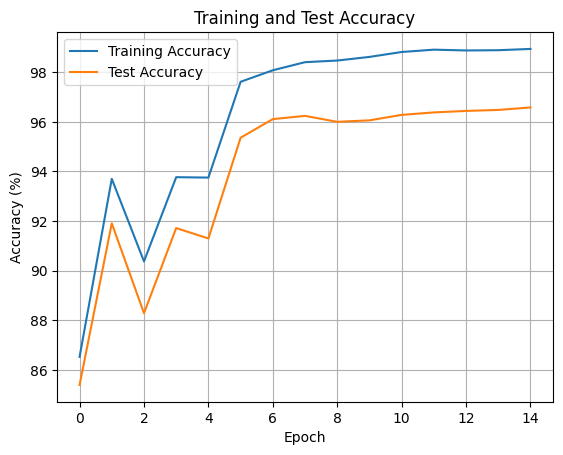

In [14]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.legend()
plt.grid()
plt.show()

In [15]:
# torch.save(teacher.state_dict(), 'teacher_finetuned_cifar10.pth')
from google.colab import drive
drive.mount('/content/drive')
torch.save(teacher.state_dict(), "/content/drive/MyDrive/Colab Notebooks/teacher_finetuned_cifar10_v2.pth")

Mounted at /content/drive
